# From https://github.com/camiladuartes/LSTM-Stock-Market-Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import math, time
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import itertools
import datetime
from operator import itemgetter
import urllib.request, json
import datetime as dt

# List all files under the input directory from kaggle
import os

In [8]:
api_key = random.choice(['F62MHL3VDUMCEMGP', '7DAKX5A7OSW2STDL', 'ELNT38TEYXQOL7WS', 'RU0OE9SIH6R38HXY', 'IXYARDFBT1Y30V7J', 'VGMETC1M5S3ME3AH', 'XG4BIITOYH3PF5GG', 'SBBSF3RLWBOPQ6E6'])

ticker = "GOOG"

# JSON file with all the stock market data for AAL from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s&datatype=csv"%(ticker,api_key)

# Save data to this file
file_to_save = './data/stock_market_data-%s.csv'%ticker

# If you haven't already saved data,
# Go ahead and grab the data from the url
# And store date, low, high, volume, close, open values to a Pandas DataFrame
# if not os.path.exists(file_to_save):
#     with urllib.request.urlopen(url_string) as url:
#         print("Response from Alpha Vantage:", url.getcode())
#         data = json.loads(url.read().decode())
#         print("Data fetched from Alpha Vantage:", data)
#         # extract stock market data
#         data = data['Time Series (Daily)']
#         df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
#         for k,v in data.items():
#             date = dt.datetime.strptime(k, '%Y-%m-%d')
#             data_row = [date.date(),float(v['3. low']),float(v['2. high']),
#                         float(v['4. close']),float(v['1. open'])]
#             df.loc[-1,:] = data_row
#             df.index = df.index + 1
#     print('Data saved to : %s'%file_to_save)        
#     df.to_csv(file_to_save)
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        print("Response from Alpha Vantage:", url.getcode())
        data = pd.read_csv(url)
        print("Data fetched from Alpha Vantage:", data.head())
        # Save the DataFrame to a CSV file
        data.to_csv(file_to_save, index=False)
        print('Data saved to : %s' % file_to_save)


Response from Alpha Vantage: 200
Data fetched from Alpha Vantage:                                                    {
0      "Information": "We have detected your API ...
1                                                  }
Data saved to : ./data/stock_market_data-GOOG.csv


/tmp/ipykernel_2166611/934414564.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad')


             TSLA        BABA        AAPL        GOOG
count  354.000000  354.000000  354.000000  354.000000
mean   255.118757   91.850424  210.801977  167.821356
std     78.415411   20.762655   24.143390   16.089174
min    142.050000   68.050000  165.000000  132.560000
25%    189.035000   75.520000  189.327500  156.595000
50%    236.060000   84.020000  216.770000  167.200000
75%    292.742500  104.012500  228.460000  177.632500
max    479.860000  147.570000  259.020000  207.710000


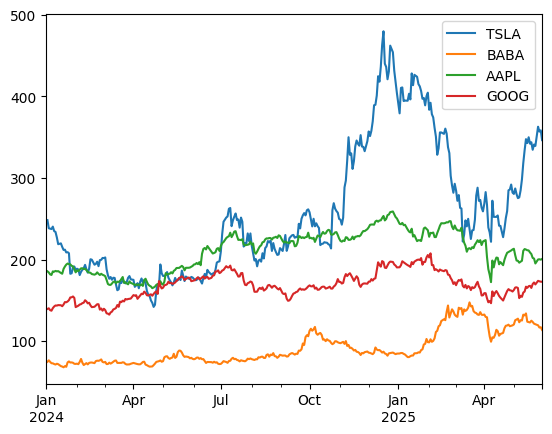

In [17]:
def stocksData(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        dfTemp = pd.read_csv("data/stock_market_data-{}.csv".format(symbol), index_col='timestamp',
                parse_dates=True, usecols=['timestamp', 'close'], na_values=['NaN'])
        dfTemp = dfTemp.rename(columns={'close': symbol})
        # Add the column to the DataFrame:
        df = df.join(dfTemp)
    return df
                              
# freq ‘B’ = business daily:
dates = pd.date_range('2024-01-01','2025-5-31',freq='B')
symbols = ['TSLA', 'BABA', 'AAPL', 'GOOG',
            # 'SP500', 'DJIA', 'NIKKEI225'
            ]
df = stocksData(symbols, dates)
# method 'pad': fill values forward(propagate last valid observation forward to next valid backfill):
df.fillna(method='pad')
print(df.describe())
df.interpolate().plot()
plt.show()

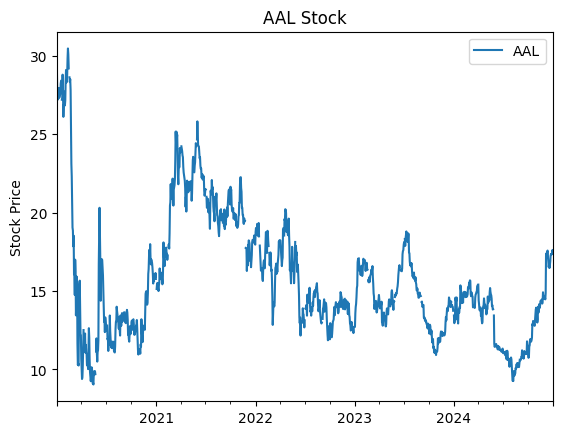

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2020-01-02 to 2024-12-31
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAL     1258 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In [6]:
dates = pd.date_range('2020-01-02','2024-12-31',freq='B')
symbols = ['AAL']
df1 = pd.DataFrame(index=dates)
dfAAL = stocksData(symbols, dates)
dfAAL = df1.join(dfAAL)
dfAAL = dfAAL[['AAL']]
dfAAL.plot()
plt.ylabel("Stock Price")
plt.title("AAL Stock")
plt.show()
dfAAL.info()

In [7]:
# 'ffill'is like'pad': fill values forward(propagate last valid observation forward to next valid backfill):
dfAal = dfAAL.fillna(method='ffill')

# MinMaxScaler: transform features by scaling each feature to a given range
scaler = MinMaxScaler(feature_range=(-1,1))
# reshape(-1,1): We have provided column as 1 but rows as unknown(numpy will figure out)
dfAal['AAL'] = scaler.fit_transform(dfAal['AAL'].values.reshape(-1,1))
dfAal

/tmp/ipykernel_26730/443460800.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfAal = dfAAL.fillna(method='ffill')


,AAL
2020-01-02,0.871209
2020-01-03,0.736818
2020-01-06,0.706020
2020-01-07,0.696687
2020-01-08,0.754550
...,...
2024-12-25,-0.224452
2024-12-26,-0.224452
2024-12-27,-0.224452
2024-12-30,-0.199253


In [8]:
# Function that creates train and test data through stock data and sequence lenght
def loadData(stock, lookBack):
    data = []
    # Convert to numpy array
    dataRaw = stock.values
    
    # Create all possible sequences of length sequence length
    for i in range(len(dataRaw)-lookBack):
        data.append(dataRaw[i: i+lookBack])
        
    data = np.array(data)
    testSize = int(np.round(0.2*data.shape[0]))
    trainSize = data.shape[0]-testSize
    
    X_train = data[:trainSize,:-1,:]
    y_train = data[:trainSize,-1,:]
    X_test = data[trainSize:,:-1]
    y_test = data[trainSize:,-1,:]
    
    return X_train, X_test, y_train, y_test    
    
# Sequence length:
lookBack = 20
X_train, X_test, y_train, y_test = loadData(dfAal, lookBack)
print("X_train and y_train shapes:", X_train.shape, y_train.shape)
print("X_test and y_test shapes:", X_test.shape, y_test.shape)

X_train and y_train shapes: (1027, 19, 1) (1027, 1)
X_test and y_test shapes: (257, 19, 1) (257, 1)


In [9]:
# Training and test sets in Pytorch(turning into tensors)
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
X_train.size(), y_train.size(), X_test.size(), y_test.size()

(torch.Size([1027, 19, 1]),
 torch.Size([1027, 1]),
 torch.Size([257, 19, 1]),
 torch.Size([257, 1]))

In [11]:
stepsNumb = lookBack-1
# Batch: number of training examples utilized in which(one) iteration of the epochs
batchSize = 1606
# Epoch: the number of passes into the entire training dataset
numEpochs = 100

# Training and test dataset with torch:

train = torch.utils.data.TensorDataset(X_train,y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

trainLoader = torch.utils.data.DataLoader(dataset=train, batch_size=batchSize, shuffle=False)
testLoader = torch.utils.data.DataLoader(dataset=test, batch_size=batchSize,shuffle=False)

In [13]:
# Build model
device = torch.device("cuda")
# Hyperparameters
inputDim = 1
hiddenDim = 32
numLayers = 2
outputDim = 1

# Defining the model as a class
# nn.Module: base class for all neural network modules, your models should also subclass this class
class LSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, numLayers, outputDim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hiddenDim = hiddenDim
        # Number of hidden layers
        self.numLayers = numLayers
        
        # Building your LSTM
        # batch_first=True: if input and output tensors are provided as (batch, seq, feature): the batch is the first access
        self.lstm = nn.LSTM(inputDim, hiddenDim, numLayers, batch_first=True)
        
        # Fully connected, Readout layer(parameters of the final non-recurrent output layer)
        self.fc = nn.Linear(hiddenDim, outputDim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # requires_grad_() = allows for fine grained exclusion of subgraphs from gradient computation and can increase efficiency
        # Gradient: is another word for "slope"
        # x.size(0): number of examples sent into the batch size
        h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenDim).requires_grad_().to(device)

        # Initialize cell state
        # Cell state: horizontal line running through the top of the diagram. It runs straight down the entire 
        ## chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.
        c0 = torch.zeros(self.numLayers, x.size(0), self.hiddenDim).requires_grad_().to(device)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # datach(): returns a new Tensor, detached from the current graph. The result will never require gradient
        out, (hiddenState, cellState) = self.lstm(x, (h0.detach(), c0.detach()))

        # Hidden state index of last time step
        # out.size() --> 100, 28, 100
        out = self.fc(out[:, -1, :]) # --> 100, 100

        # out.size() --> 100, 10
        return out
        
model = LSTM(inputDim=inputDim, hiddenDim=hiddenDim, numLayers=numLayers, outputDim=outputDim).to(device)

# MSE: Creates a criterion that measures the mean squared error between each element in the input x and target y
lossFn = torch.nn.MSELoss()

# Optimiser: will hold the current state and will update the parameters based on the computed gradients
# lr: learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [14]:
# Train model

trainLoss = np.zeros(numEpochs)

# Number of steps to unroll
seqDim = lookBack-1

device = torch.device("cuda:0")

for e in range(numEpochs):
    # Forward pass
    yTrainPred = model(X_train.to(device))
    
    loss = lossFn(yTrainPred, y_train.to(device))
    if e % 10 == 0 and e != 0:
        print("Epoch: ", e, "MSE: ", loss.item())
    trainLoss[e] = loss.item()
    
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
    
    # Backwark pass
    loss.backward()
    
    # Update parameters
    optimiser.step()

Epoch:  10 MSE:  0.04296381399035454
Epoch:  20 MSE:  0.015575002878904343
Epoch:  30 MSE:  0.010017761960625648
Epoch:  40 MSE:  0.0079977847635746
Epoch:  50 MSE:  0.006609034724533558
Epoch:  60 MSE:  0.005907099694013596
Epoch:  70 MSE:  0.005436180625110865
Epoch:  80 MSE:  0.005010015331208706
Epoch:  90 MSE:  0.004596087150275707


yTrainPred shape:  torch.Size([1027, 1])


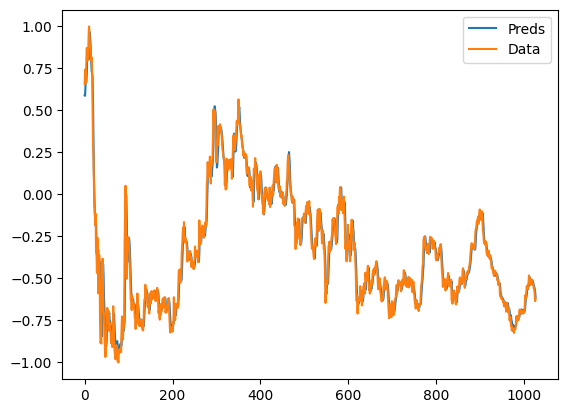

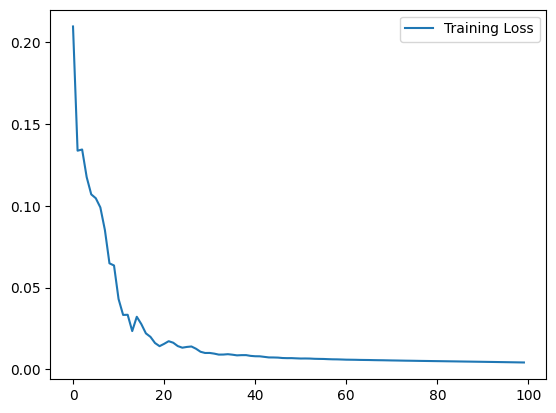

In [15]:
print("yTrainPred shape: ", np.shape(yTrainPred))

plt.plot(yTrainPred.detach().cpu().numpy(), label="Preds")
plt.plot(y_train.detach().cpu().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(trainLoss, label="Training Loss")
plt.legend()
plt.show()

In [16]:
# Make predictions
yTestPred = model(X_test.to(device))

# Invert predictions(scale back the data to the original representation)
yTrainPred = scaler.inverse_transform(yTrainPred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
yTestPred = scaler.inverse_transform(yTestPred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

# Calculate Root Mean Squared Error
trainScore = math.sqrt(mean_squared_error(yTrainPred[:,0], y_train[:,0]))
testScore = math.sqrt(mean_squared_error(yTestPred[:,0], y_test[:,0]))
print('Train Score: ', trainScore,'RMSE')
print('Test Score: ', testScore,'RMSE')

Train Score:  0.6936605309883045 RMSE
Test Score:  0.4279103896761877 RMSE


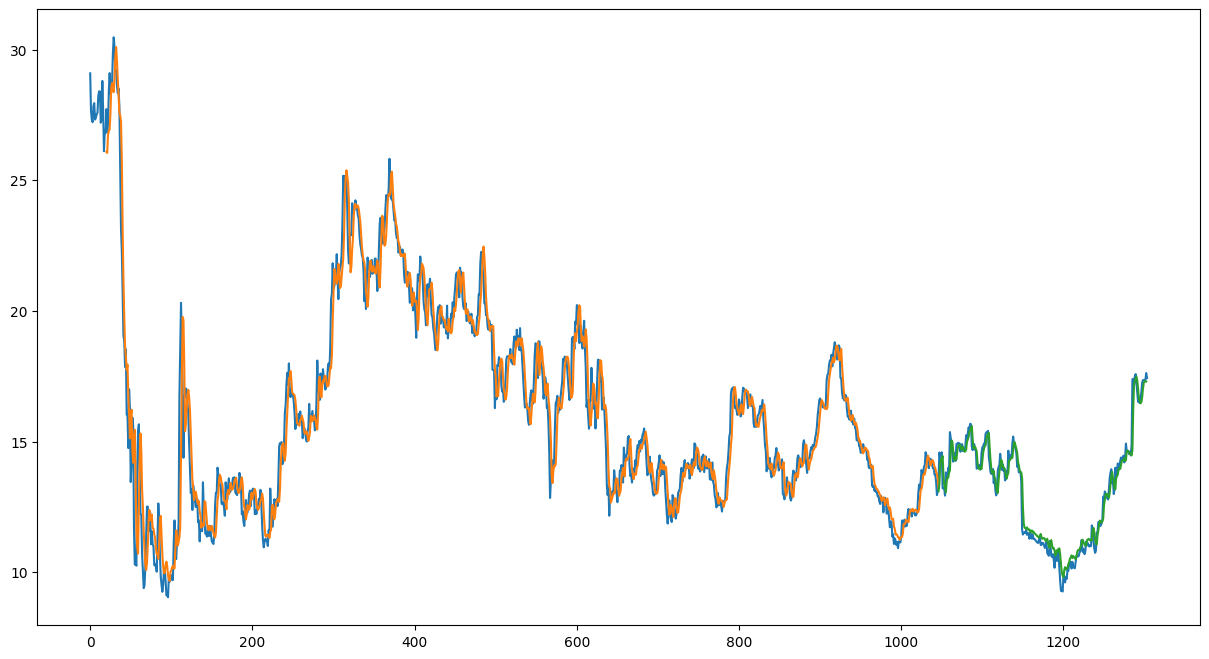

In [17]:
# Shift train predictions for plotting
# np.empty_like: returns a new array with the same shape and type as a given array
trainPredictPlot = np.empty_like(dfAal)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookBack:len(yTrainPred)+lookBack,:] = yTrainPred

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dfAal)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(yTrainPred)+lookBack-1:len(dfAal)-1,:] = yTestPred

# Plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dfAal))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predicting for sample 1/257...


Predicting for sample 51/257...
Predicting for sample 101/257...
Predicting for sample 151/257...
Predicting for sample 201/257...


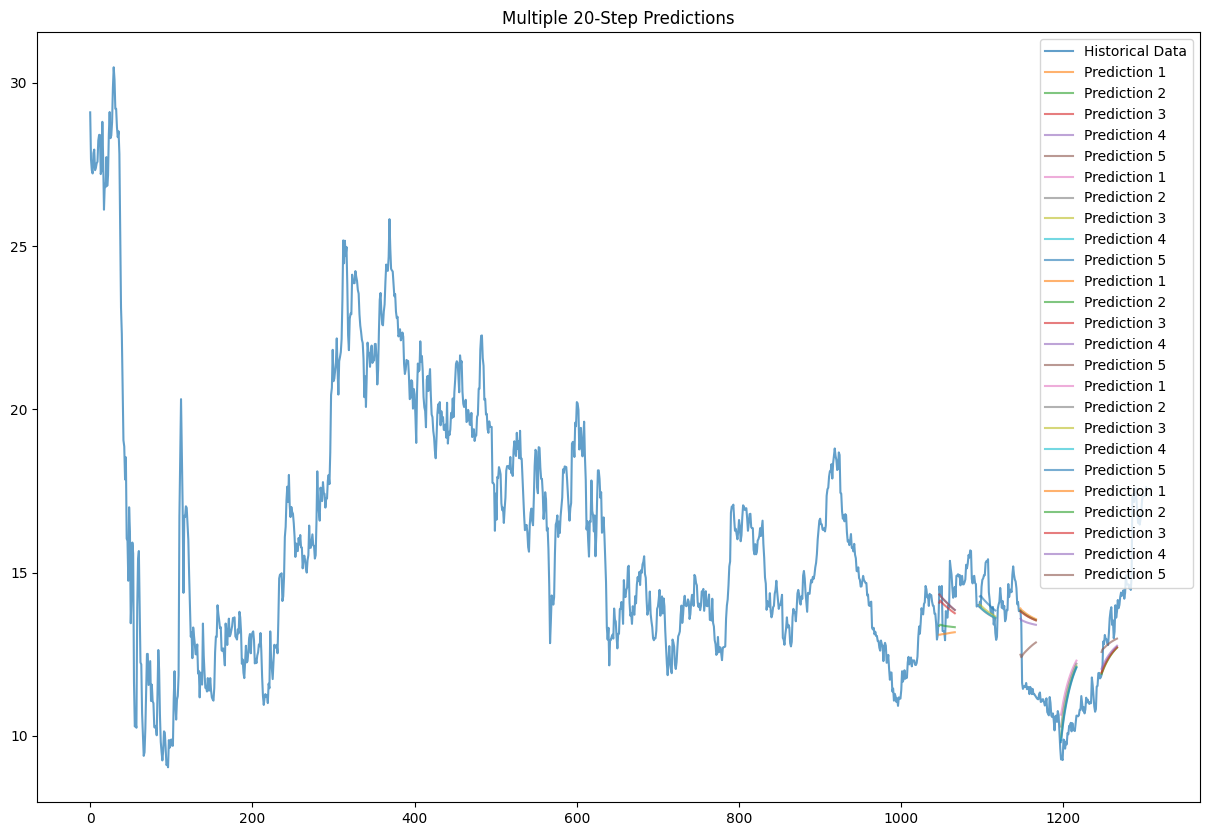

In [18]:
def predict_multiple_steps(model, last_sequence, num_steps, device):
    """
    递归预测多个时间步
    
    Args:
        model: 训练好的LSTM模型
        last_sequence: 最后的输入序列 (1, seq_len, 1)
        num_steps: 要预测的步数
        device: 设备
    
    Returns:
        predictions: 预测结果列表
    """
    model.eval()
    predictions = []
    current_sequence = last_sequence.clone()
    
    with torch.no_grad():
        for _ in range(num_steps):
            # 预测下一个值
            pred = model(current_sequence.to(device))
            predictions.append(pred.cpu().numpy())
            
            # 更新序列：移除第一个元素，添加预测值
            current_sequence = torch.cat([
                current_sequence[:, 1:, :],  # 移除第一个时间步
                pred.unsqueeze(1)            # 添加预测值作为新的时间步
            ], dim=1)
    
    return np.array(predictions).reshape(-1, 1)
def enhanced_multi_step_prediction(model, X_test, num_future_steps, device, scaler):
    """
    增强版多步预测，结合置信区间
    """
    model.eval()
    all_predictions = []
    
    # 对每个测试样本进行多步预测
    with torch.no_grad():
        for i in range(len(X_test)):
            sequence = torch.FloatTensor(X_test[i:i+1]).to(device)  # 获取单个样本并转换为张量
            predictions = predict_multiple_steps(model, sequence, num_future_steps, device)
            all_predictions.append(predictions)
    
    return np.array(all_predictions)

# 使用示例
future_steps = 20
start_idx = 0
end_idx = len(X_test)-10  # 可以根据需要调整预测的样本范围
plt.figure(figsize=(15, 10))
plt.plot(scaler.inverse_transform(dfAal), label='Historical Data', alpha=0.7)
for j in range(start_idx,end_idx, 50):
    print(f"Predicting for sample {j+1}/{len(X_test)}...")
    future_preds = enhanced_multi_step_prediction(model, X_test[j:j+10], future_steps, device, scaler)

    # 可视化多个预测轨迹

    for i in range(min(5, len(future_preds))):  # 显示前5个预测
        # start_idx = len(dfAal) - len(X_test) + i
        future_index = range(len(dfAal) - len(X_test)+j, len(dfAal) - len(X_test)+j + future_steps)
        plt.plot(future_index, scaler.inverse_transform(future_preds[i]), 
                alpha=0.6, label=f'Prediction {i+1}')

plt.legend()
plt.title(f'Multiple {future_steps}-Step Predictions')
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class StockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=6, output_dim=1, 
                 max_seq_len=100, dropout=0.1):
        super(StockTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_dim = input_dim
        self.max_seq_len = max_seq_len
        
        # Input projection layer
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_dim)
        )
        
    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape
        
        # Project input to d_model dimensions
        x = self.input_projection(x) * math.sqrt(self.d_model)
        
        # Add positional encoding
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)
        
        # Apply transformer encoder
        if mask is not None:
            output = self.transformer_encoder(x, src_key_padding_mask=mask)
        else:
            output = self.transformer_encoder(x)
        
        # Use the last time step for prediction
        output = output[:, -1, :]  # (batch_size, d_model)
        
        # Apply dropout and output projection
        output = self.dropout(output)
        output = self.output_projection(output)
        
        return output

# Alternative: Multi-step prediction model
class MultiStepStockTransformer(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=6, 
                 output_steps=5, max_seq_len=100, dropout=0.1):
        super(MultiStepStockTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_dim = input_dim
        self.output_steps = output_steps
        self.max_seq_len = max_seq_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layers for multi-step prediction
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_steps)
        )
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project and add positional encoding
        x = self.input_projection(x) * math.sqrt(self.d_model)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        
        # Apply transformer
        if mask is not None:
            output = self.transformer_encoder(x, src_key_padding_mask=mask)
        else:
            output = self.transformer_encoder(x)
        
        # Use last time step for multi-step prediction
        output = output[:, -1, :]
        output = self.dropout(output)
        output = self.output_projection(output)
        
        return output

# Example usage and training setup
def create_stock_model(input_features=5, sequence_length=60, prediction_steps=1):
    """
    Create a stock prediction transformer model
    
    Args:
        input_features: Number of input features (e.g., OHLCV = 5)
        sequence_length: Length of input sequences
        prediction_steps: Number of future steps to predict
    """
    
    if prediction_steps == 1:
        model = StockTransformer(
            input_dim=input_features,
            d_model=256,
            nhead=8,
            num_layers=4,
            output_dim=1,
            max_seq_len=sequence_length,
            dropout=0.1
        )
    else:
        model = MultiStepStockTransformer(
            input_dim=input_features,
            d_model=256,
            nhead=8,
            num_layers=4,
            output_steps=prediction_steps,
            max_seq_len=sequence_length,
            dropout=0.1
        )
    
    return model

# Training function example
def train_stock_transformer(model, train_loader, val_loader, device, num_epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

# Example instantiation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For single-step prediction (predicting next day's price)
model_single = create_stock_model(
    input_features=5,  # OHLCV features
    sequence_length=60,  # 60 days of history
    prediction_steps=1
).to(device)

# For multi-step prediction (predicting next 5 days)
model_multi = create_stock_model(
    input_features=5,
    sequence_length=60,
    prediction_steps=5
).to(device)

print(f"Single-step model parameters: {sum(p.numel() for p in model_single.parameters()):,}")
print(f"Multi-step model parameters: {sum(p.numel() for p in model_multi.parameters()):,}")

Single-step model parameters: 3,193,601
Multi-step model parameters: 3,194,117
